# Transit detection

In [1]:
from prose import Fluxes

/Users/lgarcia/mambaforge/envs/pysnack10/lib/python3.11/site-packages/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
data = Fluxes.load("../data/TRAPPIST-South_20150916_UCDTS-48_I+z.flux")
# data = Fluxes.load("../data/TRAPPIST-South_20150928_UCDTS-48_I+z.flux")
time = data.time
flux = data.flux

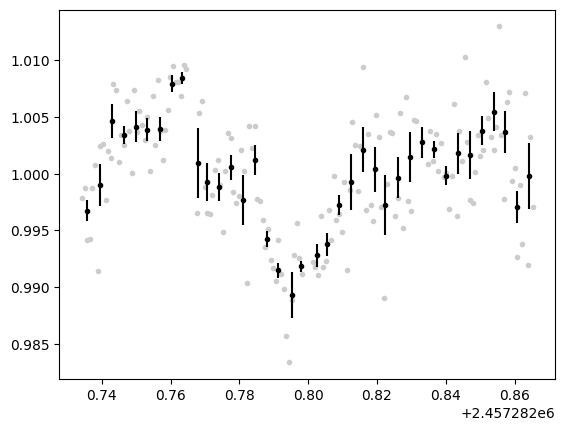

In [3]:
data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()

In [4]:
import jax

jax.config.update("jax_enable_x64", True)

import nuance as nu

In [5]:
data.data.keys()

dict_keys(['bkg', 'flip', 'airmass', 'dx', 'dy', 'fwhm'])

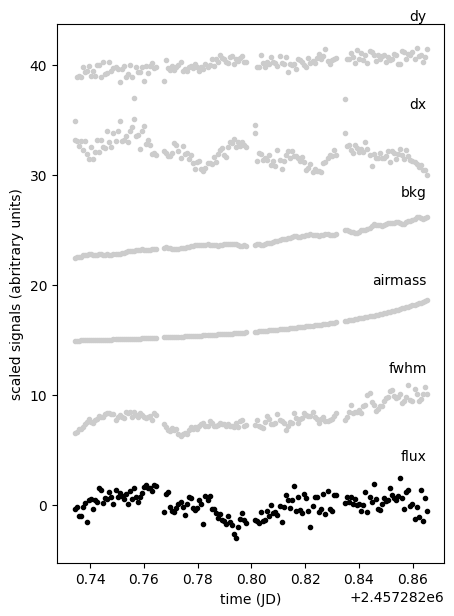

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(None, (5, 7))
ax = plt.subplot(xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy"]):
    y = data.df[name].copy()
    y = (y - np.mean(y)) / np.std(y) + 8 * i
    plt.text(data.time.max(), np.mean(y) + 4, name, ha="right")
    plt.plot(data.time, y, ".", c="0.8" if name != "flux" else "k")

In [8]:
import numpy as np

X = np.vstack(
    [
        np.ones_like(data.time),
        data.data["airmass"],
        data.data["fwhm"],
        data.data["bkg"],
        data.data["dx"],
        data.data["dy"],
    ]
)

In [9]:
ls_function = nu.linear_search(time, flux, X=X)

epochs = np.linspace(time.min(), time.max(), 400)
durations = np.linspace(0.01, 0.08, 30)

lls, depths, vars = ls_function(epochs, durations)

100%|██████████| 401/401 [00:00<00:00, 1.15kit/s]


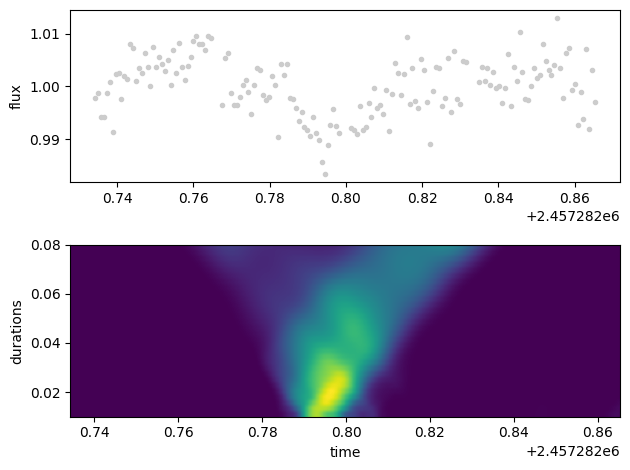

In [10]:
plt.subplot(211)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")

plt.subplot(212)
plt.imshow(
    lls.T,
    aspect="auto",
    origin="lower",
    extent=[time.min(), time.max(), durations.min(), durations.max()],
)
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()

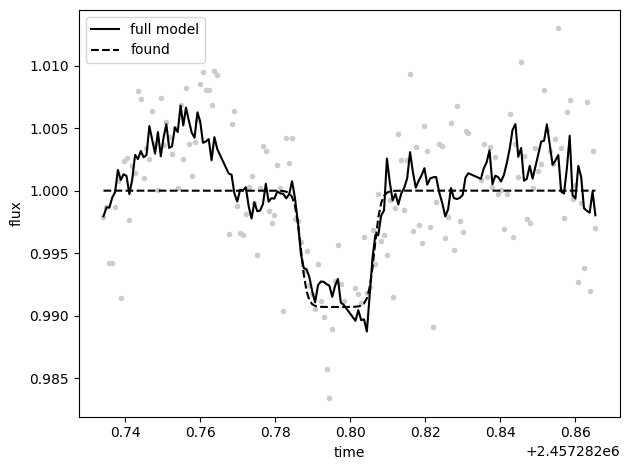

In [11]:
from nuance import core

i, duration_i = np.unravel_index(np.argmax(lls), lls.shape)
t0, D = epochs[i], durations[duration_i]

linear, astro, noise = core.separate_models(time, flux, X=X)(t0, D)

plt.plot(time, flux, ".", c="0.8")
plt.plot(time, linear + astro + noise, c="k", label="full model")
plt.plot(time, astro + 1.0, ls="--", c="k", label="found")
plt.legend()
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()